In [1]:
#!pip install xdggs pint_xarray icechunk
!pip install xdggs
!pip install healpy
!pip install -U zarr==2.18.4

In [1]:
import warnings
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xdggs
import fsspec
import sparse

warnings.filterwarnings("ignore")
xr.set_options(display_max_rows=27)

In [9]:
from numcodecs import Zstd


class proj_odysea:

    def __init__(
        self,
        nside,
        multiscale=0,
        sz_orbit=100000,
        nest=False,
        chunk_size=4096,
        cell_id_name="cell_ids",
    ):
        self.nside = nside
        self.multiscale = multiscale
        self.sz_orbit = sz_orbit
        self.nest = nest
        self.chunk_size = chunk_size
        self.cell_id_name = cell_id_name
        # Configuration du compresseur (Zstandard) avec la valeur de remplissage

    def setalldata(self, val, cell_ids):
        data = np.full(12 * self.nside**2, np.nan)
        data[cell_ids] = val
        return data.reshape(12 * self.nside**2, 1)

    def eval(self, url, angle=[], time=[], orbit=0):

#        fs = fsspec.filesystem("http")
#        ds = xr.open_dataset(fs.open(url), engine="h5netcdf")
        ds = xr.open_dataset(url, engine="h5netcdf")

        var_name = list(ds.data_vars)

        mask = ~np.isnan(ds.u_model.data)

        hidx = hp.ang2pix(
            self.nside,
            ds.lon.values[mask],
            ds.lat.values[mask],
            lonlat=True,
            nest=self.nest,
        ).flatten()

        him = np.bincount(hidx, minlength=12 * self.nside**2)

        cell_ids = np.where(him > 0)[0]

        out_map = []

        healpix_ids = np.arange(12 * self.nside**2)
        var_cell_ids = xr.DataArray(
            healpix_ids,
            dims="cells",
            attrs={"grid_name": "healpix", "nside": self.nside, "nest": self.nest},
        )

        for ivar in var_name:
            if len(ds[ivar].values.shape) == 2:
                if ivar in angle:
                    c_hmap = np.bincount(
                        hidx,
                        weights=np.cos(ds[ivar].values[mask].flatten()),
                        minlength=12 * self.nside**2,
                    )
                    s_hmap = np.bincount(
                        hidx,
                        weights=np.sin(ds[ivar].values[mask].flatten()),
                        minlength=12 * self.nside**2,
                    )
                    data = self.setalldata(
                        np.arctan2(s_hmap[cell_ids], c_hmap[cell_ids]), cell_ids
                    )
                elif ivar in time:
                    print("donothing", ivar)
                    data = self.setalldata(np.zeros([cell_ids.shape[0]]), cell_ids)
                else:
                    data = np.bincount(
                        hidx,
                        weights=ds[ivar].values[mask].flatten(),
                        minlength=12 * self.nside**2,
                    )
                    data = self.setalldata(data[cell_ids] / him[cell_ids], cell_ids)

                out_map.append(
                    xr.DataArray(
                        data,
                        dims=("cells", "orbit"),
                        coords={self.cell_id_name: var_cell_ids, "orbit": [orbit]},
                        name=ivar,
                    )
                )

        ivar = "hit"
        out_map.append(
            xr.DataArray(
                self.setalldata(him[cell_ids], cell_ids),
                dims=("cells", "orbit"),
                coords={self.cell_id_name: var_cell_ids, "orbit": [orbit]},
                name=ivar,
            )
        )
        print("Orbit ", url)
        print("Npt = ", len(cell_ids))

        ds_total = xr.merge(out_map)

        chunk_size_data = int(self.chunk_size)
        print("chunk_size_data", chunk_size_data)
        ds_total = ds_total.chunk({"cells": chunk_size_data})

        return ds_total

    def plot(self, u, v):
        plt.figure(figsize=(12, 4))
        hp.cartview(
            u,
            nest=True,
            hold=False,
            sub=(1, 2, 1),
            title="U Model",
            min=-1,
            max=1,
            unit=r"$m.s^{-1}$",
            cmap="jet",
            flip="geo",
        )
        hp.cartview(
            v,
            nest=True,
            hold=False,
            sub=(1, 2, 2),
            title="V Model",
            min=-1,
            max=1,
            unit=r"$m.s^{-1}$",
            cmap="jet",
            flip="geo",
        )

In [10]:
from numcodecs import Zstd

level = 9
chunk_late = 3#*(2**level)
chunk_size = int(( 12 * (4**level)) / chunk_late)
print("chunk_size", chunk_size)

pr=proj_odysea(2**level,
               nest=True,
               chunk_size= chunk_size)

for k in range(161,274):
    url="https://data-fair2adapt.ifremer.fr/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p%d.nc"%(k)
    url="/home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p%d.nc"%(k)
    url_out="/home/jovyan/Akathon-Geilo/odysea.zarr"
    url_out="/home/lops-oh-fair2adapt/odysea/odysea.zarr"
    print(url)
    ds_data=pr.eval(url,orbit=k,
                    angle=['lat','lon','wind_dir'],
                     time=['sample_time'])
    
    ds_data = ds_data.fillna(hp.UNSEEN)
    
    zstd_compressor = Zstd(level=3)

    # Define a common compression setting
    compression_settings = {"compressor": zstd_compressor, "chunks": (chunk_size, 1)}

    # Create the encoding dictionary for all variables
    encoding = {var: compression_settings for var in ds_data.data_vars}
    
    if k==161:
        ds_data.to_zarr(url_out, 
                        mode="w",  #consolidated=True,
                        encoding=encoding)
    else:
        ds_data.to_zarr(url_out, 
                        mode="a", 
                        append_dim="orbit") #,consolidated=True)

chunk_size 1048576
/home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p161.nc
donothing sample_time
Orbit  /home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p161.nc
Npt =  143996
chunk_size_data 1048576
/home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p162.nc
donothing sample_time
Orbit  /home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p162.nc
Npt =  163573
chunk_size_data 1048576
/home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p163.nc
donothing sample_time
Orbit  /home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p163.nc
Npt =  100324
chunk_size_data 1048576
/home/lops-oh-fair2adapt/odysea/odysea/L2_global_mitgcm_confF_c13/odysea_L2_global_mitgcm_confF_c13_p164.nc
donothing sample_time
Or

In [16]:
#dtotal=xr.open_zarr("odyssea.zarr").rename_vars(dict(cells="cell_ids")).assign_coords(cell_ids=lambda ds : ds["cell_ids"].assign_attrs({"grid_name":"healpix","nside":256,"nest":True})).pipe(xdggs.decode)
ds=xr.open_zarr(url_out).pipe(xdggs.decode)
cell_centers=ds.dggs.cell_centers()
ds=ds.assign_coords(
    cell_centers.coords
)

In [17]:
ds.u_model.isel(orbit=0).where(lambda x : x!=hp.UNSEEN).compute().dggs.explore(alpha=0.8)
#dtotal.u_model.where(lambda x : x!=hp.UNSEEN).mean("orbit").compute().dggs.explore(cmap='jet',alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

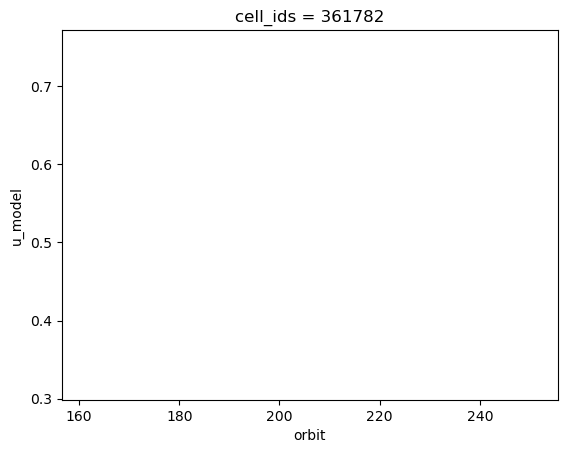

In [27]:
dtotal.u_model.isel(cells=361782).where(lambda x : x!=hp.UNSEEN).plot()